# GaussianDropoff Tutorial

This notebook shows how to use `bmtool.connectors.GaussianDropoff` for distance-dependent connection probabilities. It covers:

- What `pmax` vs `ptotal` mean and when to use each
- How parameters affect the connection curve
- Examples with plots

Run cells in order.

In [1]:
# Imports
%matplotlib inline

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bmtool.connectors import GaussianDropoff

## Quick parameter guide

- `mean` (μ): Center of the Gaussian (usually 0)
- `stdev` (σ): How spread out the curve is
- `pmax`: Peak probability at the center
- `ptotal`: Total connection probability within a distance range (class calculates `pmax` from this)
- `ptotal_dist_range`: The range for `ptotal` calculation
- `min_dist`, `max_dist`: Hard cutoffs for connections
- `dist_type`: 'spherical' (3D) or 'cylindrical' (2D)

Use `pmax` if you know the peak connection rate. Use `ptotal` if you have data on overall connection rates within a range.

## Example 1: pmax vs ptotal

Create two Gaussians: one with `pmax` set directly, one with `ptotal` (class calculates `pmax`). Plot both.

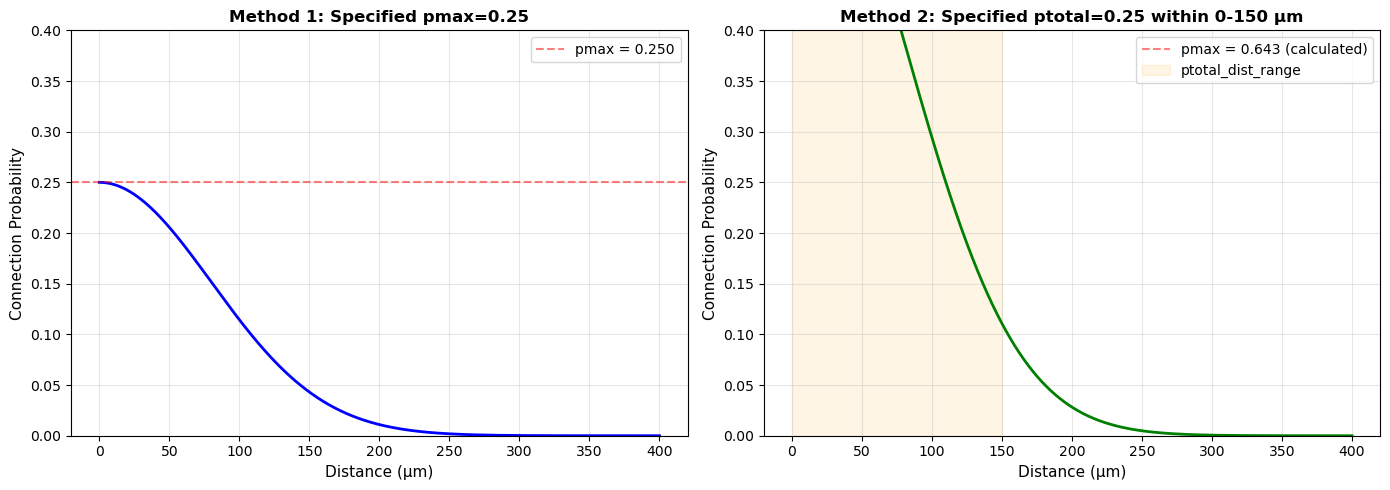

pmax method: peak = 0.2500
ptotal method: peak = 0.6434 (calculated)


In [2]:
# Method 1: Specify pmax directly
dropoff_pmax = GaussianDropoff(
    stdev=80.0,
    min_dist=0,
    max_dist=300,
    pmax=0.25,
    dist_type='spherical'
)

# Method 2: Specify ptotal - class calculates pmax
dropoff_ptotal = GaussianDropoff(
    stdev=80.0,
    min_dist=0,
    max_dist=300,
    ptotal=0.25,
    ptotal_dist_range=(0, 150),
    dist_type='spherical'
)

distances = np.linspace(0, 400, 1000)
prob_pmax = dropoff_pmax.probability(distances)
prob_ptotal = dropoff_ptotal.probability(distances)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(distances, prob_pmax, 'b-', linewidth=2)
ax1.axhline(y=0.25, color='r', linestyle='--', alpha=0.5, label=f'pmax = {dropoff_pmax.pmax:.3f}')
ax1.set_xlabel('Distance (μm)', fontsize=11)
ax1.set_ylabel('Connection Probability', fontsize=11)
ax1.set_title('Method 1: Specified pmax=0.25', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim([0, 0.4])

ax2.plot(distances, prob_ptotal, 'g-', linewidth=2)
ax2.axhline(y=dropoff_ptotal.pmax, color='r', linestyle='--', alpha=0.5, 
            label=f'pmax = {dropoff_ptotal.pmax:.3f} (calculated)')
ax2.axvspan(0, 150, alpha=0.1, color='orange', label='ptotal_dist_range')
ax2.set_xlabel('Distance (μm)', fontsize=11)
ax2.set_ylabel('Connection Probability', fontsize=11)
ax2.set_title(f'Method 2: Specified ptotal=0.25 within 0-150 μm', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim([0, 0.4])

plt.tight_layout()
plt.show()

print(f"pmax method: peak = {dropoff_pmax.pmax:.4f}")
print(f"ptotal method: peak = {dropoff_ptotal.pmax:.4f} (calculated)")

## Example 2: How ptotal_dist_range affects the curve

Same `ptotal` (25%), different ranges. See how `pmax` changes.


 ptotal may not be reached.


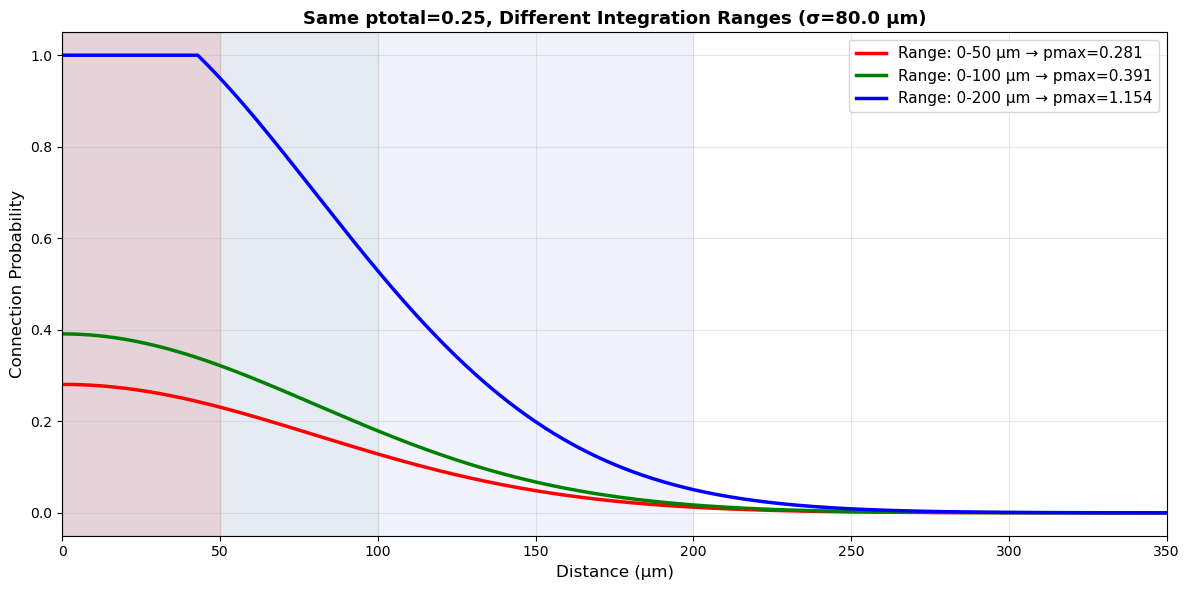

Same ptotal (25%), different ranges:
0-50 μm: pmax = 0.2807
0-100 μm: pmax = 0.3911
0-200 μm: pmax = 1.1544


In [3]:
ptotal_value = 0.25
stdev_value = 80.0

dropoff_small = GaussianDropoff(
    stdev=stdev_value, min_dist=0, max_dist=300,
    ptotal=ptotal_value, ptotal_dist_range=(0, 50),
    dist_type='spherical'
)

dropoff_medium = GaussianDropoff(
    stdev=stdev_value, min_dist=0, max_dist=300,
    ptotal=ptotal_value, ptotal_dist_range=(0, 100),
    dist_type='spherical'
)

dropoff_large = GaussianDropoff(
    stdev=stdev_value, min_dist=0, max_dist=300,
    ptotal=ptotal_value, ptotal_dist_range=(0, 200),
    dist_type='spherical'
)

distances = np.linspace(0, 400, 1000)

plt.figure(figsize=(12, 6))
plt.plot(distances, dropoff_small.probability(distances), 'r-', linewidth=2.5,
         label=f'Range: 0-50 μm → pmax={dropoff_small.pmax:.3f}')
plt.plot(distances, dropoff_medium.probability(distances), 'g-', linewidth=2.5,
         label=f'Range: 0-100 μm → pmax={dropoff_medium.pmax:.3f}')
plt.plot(distances, dropoff_large.probability(distances), 'b-', linewidth=2.5,
         label=f'Range: 0-200 μm → pmax={dropoff_large.pmax:.3f}')

plt.axvspan(0, 50, alpha=0.1, color='red')
plt.axvspan(0, 100, alpha=0.05, color='green')
plt.axvspan(0, 200, alpha=0.05, color='blue')

plt.xlabel('Distance (μm)', fontsize=12)
plt.ylabel('Connection Probability', fontsize=12)
plt.title(f'Same ptotal={ptotal_value}, Different Integration Ranges (σ={stdev_value} μm)', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 350])
plt.tight_layout()
plt.show()

print("Same ptotal (25%), different ranges:")
print(f"0-50 μm: pmax = {dropoff_small.pmax:.4f}")
print(f"0-100 μm: pmax = {dropoff_medium.pmax:.4f}")
print(f"0-200 μm: pmax = {dropoff_large.pmax:.4f}")

## Example 3: Validate pmax with compute_ptotal_integral()

If you set `pmax`, use this method to check what `ptotal` it gives over different ranges.

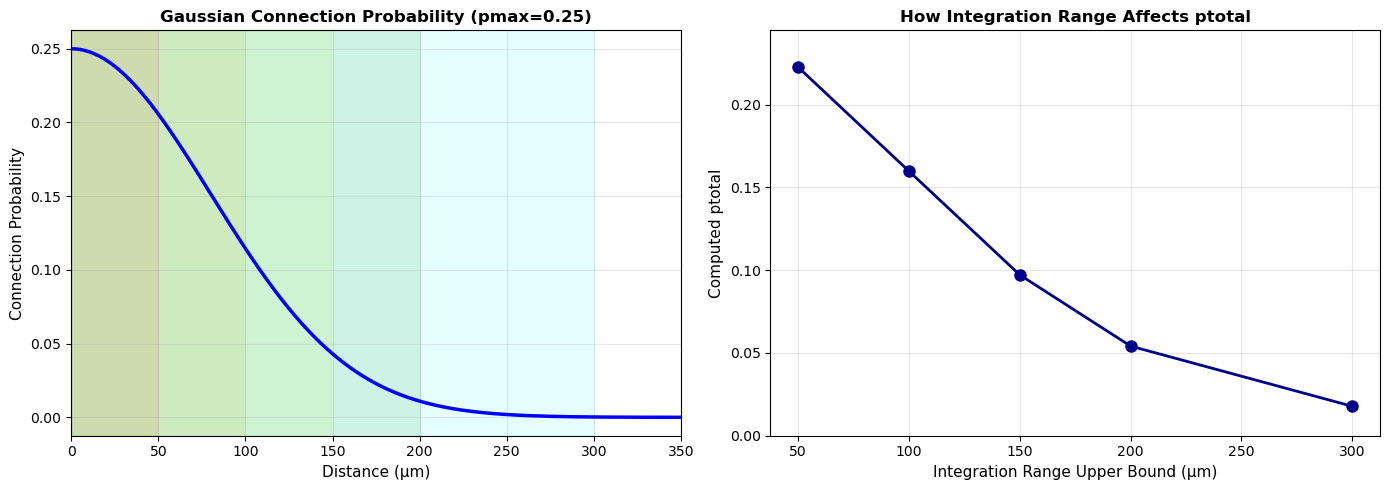

ptotal for different ranges (pmax=0.25, σ=80 μm):
0-50 μm: 0.223
0-100 μm: 0.160
0-150 μm: 0.097
0-200 μm: 0.054
0-300 μm: 0.018


In [4]:
my_dropoff = GaussianDropoff(
    stdev=80.0,
    min_dist=0,
    max_dist=300,
    pmax=0.25,
    dist_type='spherical'
)

ranges_to_check = [(0, 50), (0, 100), (0, 150), (0, 200), (0, 300)]

distances = np.linspace(0, 350, 1000)
probs = my_dropoff.probability(distances)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(distances, probs, 'b-', linewidth=2.5)
colors = ['red', 'orange', 'yellow', 'green', 'cyan']
for i, (min_d, max_d) in enumerate(ranges_to_check):
    ax1.axvspan(min_d, max_d, alpha=0.1, color=colors[i])
ax1.set_xlabel('Distance (μm)', fontsize=11)
ax1.set_ylabel('Connection Probability', fontsize=11)
ax1.set_title(f'Gaussian Connection Probability (pmax={my_dropoff.pmax})', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 350])

ptotal_values = []
for min_d, max_d in ranges_to_check:
    my_dropoff.ptotal_dist_range = (min_d, max_d)
    computed_ptotal = my_dropoff.compute_ptotal_integral(num_points=2000)
    ptotal_values.append(computed_ptotal)

range_widths = [max_d for _, max_d in ranges_to_check]
ax2.plot(range_widths, ptotal_values, 'o-', linewidth=2, markersize=8, color='darkblue')
ax2.set_xlabel('Integration Range Upper Bound (μm)', fontsize=11)
ax2.set_ylabel('Computed ptotal', fontsize=11)
ax2.set_title('How Integration Range Affects ptotal', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, max(ptotal_values) * 1.1])

plt.tight_layout()
plt.show()

print("ptotal for different ranges (pmax=0.25, σ=80 μm):")
for min_d, max_d in ranges_to_check:
    my_dropoff.ptotal_dist_range = (min_d, max_d)
    computed_ptotal = my_dropoff.compute_ptotal_integral(num_points=2000)
    print(f"{min_d}-{max_d} μm: {computed_ptotal:.3f}")

## Example 4: Spherical vs cylindrical distance

Same parameters, different `dist_type`. See how it affects `pmax`.

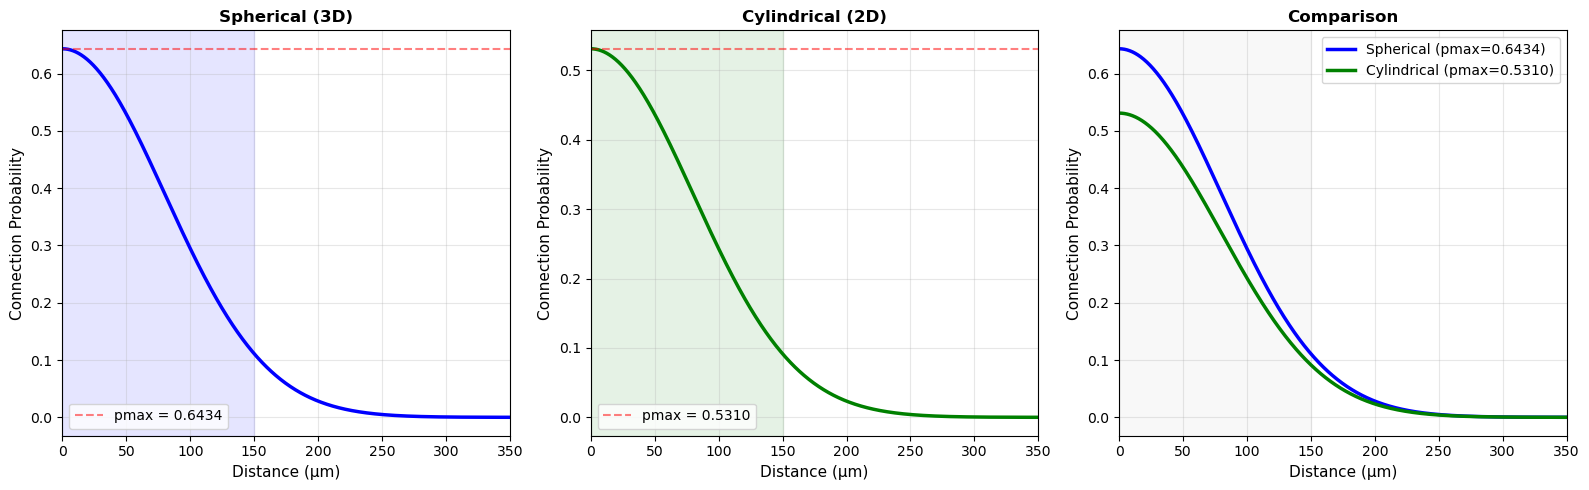

Spherical: pmax = 0.6434
Cylindrical: pmax = 0.5310
Different because of spatial weighting.


In [5]:
ptotal_val = 0.25
sigma_val = 80.0
dist_range = (0, 150)

dropoff_spherical = GaussianDropoff(
    stdev=sigma_val,
    min_dist=0,
    max_dist=300,
    ptotal=ptotal_val,
    ptotal_dist_range=dist_range,
    dist_type='spherical'
)

dropoff_cylindrical = GaussianDropoff(
    stdev=sigma_val,
    min_dist=0,
    max_dist=300,
    ptotal=ptotal_val,
    ptotal_dist_range=dist_range,
    dist_type='cylindrical'
)

distances = np.linspace(0, 350, 1000)
prob_spherical = dropoff_spherical.probability(distances)
prob_cylindrical = dropoff_cylindrical.probability(distances)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].plot(distances, prob_spherical, 'b-', linewidth=2.5)
axes[0].axhline(y=dropoff_spherical.pmax, color='r', linestyle='--', alpha=0.5,
                label=f'pmax = {dropoff_spherical.pmax:.4f}')
axes[0].axvspan(dist_range[0], dist_range[1], alpha=0.1, color='blue')
axes[0].set_xlabel('Distance (μm)', fontsize=11)
axes[0].set_ylabel('Connection Probability', fontsize=11)
axes[0].set_title("Spherical (3D)", fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 350])

axes[1].plot(distances, prob_cylindrical, 'g-', linewidth=2.5)
axes[1].axhline(y=dropoff_cylindrical.pmax, color='r', linestyle='--', alpha=0.5,
                label=f'pmax = {dropoff_cylindrical.pmax:.4f}')
axes[1].axvspan(dist_range[0], dist_range[1], alpha=0.1, color='green')
axes[1].set_xlabel('Distance (μm)', fontsize=11)
axes[1].set_ylabel('Connection Probability', fontsize=11)
axes[1].set_title("Cylindrical (2D)", fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 350])

axes[2].plot(distances, prob_spherical, 'b-', linewidth=2.5, label=f'Spherical (pmax={dropoff_spherical.pmax:.4f})')
axes[2].plot(distances, prob_cylindrical, 'g-', linewidth=2.5, label=f'Cylindrical (pmax={dropoff_cylindrical.pmax:.4f})')
axes[2].axvspan(dist_range[0], dist_range[1], alpha=0.05, color='gray')
axes[2].set_xlabel('Distance (μm)', fontsize=11)
axes[2].set_ylabel('Connection Probability', fontsize=11)
axes[2].set_title('Comparison', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([0, 350])

plt.tight_layout()
plt.show()

print("Spherical: pmax =", f"{dropoff_spherical.pmax:.4f}")
print("Cylindrical: pmax =", f"{dropoff_cylindrical.pmax:.4f}")
print("Different because of spatial weighting.")

## Example 5: Parameter effects

How `stdev` and `mean` change the curve.

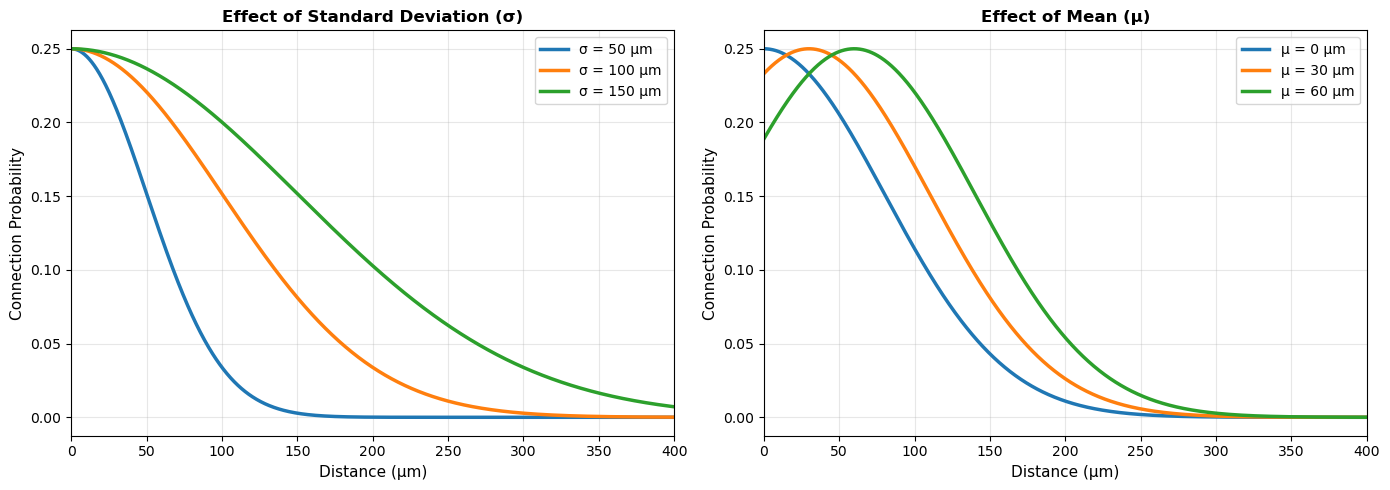

Parameter Effects:
stdev (σ): Controls how spread out connections are. Smaller σ means connections drop off faster.
mean (μ): Shifts the peak. Usually 0, but can model connections peaking at specific distances.


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
distances = np.linspace(0, 400, 1000)

# ============== Panel 1: Effect of stdev (σ) ==============
ax = axes[0]
stdev_values = [50, 100, 150]
for sigma in stdev_values:
    drop = GaussianDropoff(stdev=sigma, min_dist=0, max_dist=300, pmax=0.25, dist_type='spherical')
    ax.plot(distances, drop.probability(distances), linewidth=2.5, label=f'σ = {sigma} μm')

ax.set_xlabel('Distance (μm)', fontsize=11)
ax.set_ylabel('Connection Probability', fontsize=11)
ax.set_title('Effect of Standard Deviation (σ)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 400])

# ============== Panel 2: Effect of mean (μ) ==============
ax = axes[1]
mean_values = [0, 30, 60]
for mu in mean_values:
    drop = GaussianDropoff(mean=mu, stdev=80, min_dist=0, max_dist=300, pmax=0.25, dist_type='spherical')
    ax.plot(distances, drop.probability(distances), linewidth=2.5, label=f'μ = {mu} μm')

ax.set_xlabel('Distance (μm)', fontsize=11)
ax.set_ylabel('Connection Probability', fontsize=11)
ax.set_title('Effect of Mean (μ)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 400])

plt.tight_layout()
plt.show()

print("Parameter Effects:")
print("stdev (σ): Controls how spread out connections are. Smaller σ means connections drop off faster.")
print("mean (μ): Shifts the peak. Usually 0, but can model connections peaking at specific distances.")